The problem statement:
https://gym.openai.com/envs/LunarLander-v2/

In [5]:
%load_ext autoreload
%autoreload 2

import gym
!pip3 install box2d
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from pacman_RAM_agent import Agent

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
env = gym.make('MsPacman-ram-v0')
env.seed(0)
state_space = env.observation_space.shape[0]
action_space = env.action_space.n
print('State shape: ', state_space)
print('Number of actions: ', action_space)

State shape:  128
Number of actions:  9


In [7]:
def skipped_step(e, a, duration=2):
    (s, r, d) = ([], [], [])
    for i in range(duration):
        si, ri, di, _ = e.step(a)
        s.append(si)
        r.append(ri)
        d.append(di)
    s2, r2, d2, _ = e.step(a)
    ss = np.stack(s).max(0)
    return ss, np.mean(r), max(d)

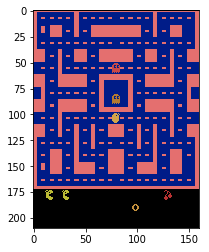

In [8]:
s = env.reset()
sn, rn, dn = skipped_step(env, 0, duration=2)
img = plt.imshow(env.render(mode='rgb_array'))

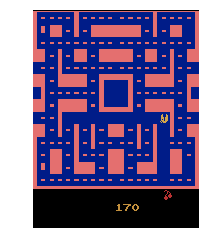

In [9]:
untrained_agent = Agent(state_size=state_space, action_size=action_space, seed=10)

# watch an untrained agent
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(1000):
    action = untrained_agent.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    state, reward, done = skipped_step(env, action)
    if done:
        break 
        
env.close()

In [10]:
agent = Agent(state_size=state_space, action_size=action_space, seed=0)

Episode 20	Average Score: 118.50

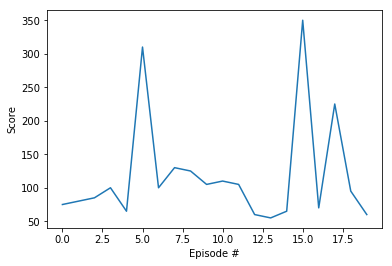

In [15]:
model_dir = 'saved_models/'
model_name = 'MsPacman-ram-v0-deep.pt'

def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.9995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            #next_state, reward, done, _ = env.step(action)
            next_state, reward, done = skipped_step(env, action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\teps: {:.2f}'.format(i_episode, np.mean(scores_window), eps))
        
        if np.mean(scores_window)>=1000.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,
                                                                                         np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), model_dir+model_name)
            break
        
    return scores

scores = dqn(20)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [16]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'MsPacman-ram-v0.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(agent.qnetwork_local.state_dict(), model_dir+model_name)

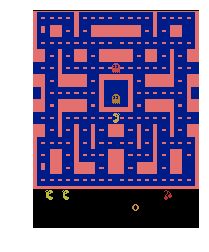

In [ ]:
# load the weights from file
#torch.load(agent.qnetwork_local.state_dict(), model_dir+model_name)

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(1000):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()